In [1]:
from keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf
from yahoofinancials import YahooFinancials

import datetime

In [2]:
yahoo_financials = YahooFinancials('GOOGL')
data=yahoo_financials.get_historical_price_data("2016-07-10", "2021-01-27", "daily")
full_data = pd.DataFrame(data['GOOGL']['prices'])
full_data = full_data.drop('date', axis=1)
full_data.head()

,high,low,open,close,volume,adjclose,formatted_date
0,728.929993,718.869995,719.419983,727.200012,1441100,727.200012,2016-07-11
1,735.599976,727.500000,731.919983,732.510010,1323400,732.510010,2016-07-12
2,735.520020,729.020020,735.520020,729.479980,1021800,729.479980,2016-07-13
3,736.140015,730.590027,733.940002,735.799988,1070400,735.799988,2016-07-14
4,741.000000,734.640015,741.000000,735.630005,1617100,735.630005,2016-07-15


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

dates = full_data['formatted_date']
df = full_data[['high', 'low', 'open', 'volume', 'adjclose', 'close']]
df.head()

,high,low,open,volume,adjclose,close
0,728.929993,718.869995,719.419983,1441100,727.200012,727.200012
1,735.599976,727.500000,731.919983,1323400,732.510010,732.510010
2,735.520020,729.020020,735.520020,1021800,729.479980,729.479980
3,736.140015,730.590027,733.940002,1070400,735.799988,735.799988
4,741.000000,734.640015,741.000000,1617100,735.630005,735.630005


In [4]:
def _create_dataset(dataset, future_days, past_days):
    dataset = dataset.to_numpy()
    X_scaler = MinMaxScaler(feature_range=(-1,1))
    X_scaled = X_scaler.fit_transform(dataset[:,0:dataset.shape[1]-1])

    y_scaler = MinMaxScaler(feature_range=(-1,1))
    y_scaled = y_scaler.fit_transform(dataset[:,-1].reshape(-1, 1))

    dataset = np.hstack((X_scaled, y_scaled))

    X_train, y_train = [], []
    for i in range(past_days, len(dataset) - future_days + 1):
        X_train.append(dataset[i - past_days:i, 0:dataset.shape[1] - 1])
        y_train.append(dataset[i + future_days - 1:i + future_days, 5])

    X_train, y_train = np.array(X_train), np.array(y_train)

    print('X_train shape == {}.'.format(X_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))

    return X_train, y_train, X_scaler, y_scaler

In [5]:
X_train, y_train, X_scaler, y_scaler = _create_dataset(df, 45, 180)

X_train shape == (921, 180, 5).
y_train shape == (921, 1).


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [95]:
model = Sequential()
model.add(Conv1D(32, 171, activation='relu', input_shape=(180, X_train.shape[2])))
model.add(MaxPooling1D(1,1))
model.add((LSTM(64, return_sequences=True)))
model.add((LSTM(32)))
model.add(Dense(16))
model.add(Dense(1))
model.build()
model.summary()

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(X_train, y_train, epochs=100,
                        batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stop])

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 10, 32)            27392     
                                                                 
 max_pooling1d_47 (MaxPoolin  (None, 10, 32)           0         
 g1D)                                                            
                                                                 
 lstm_63 (LSTM)              (None, 10, 64)            24832     
                                                                 
 lstm_64 (LSTM)              (None, 32)                12416     
                                                                 
 dense_40 (Dense)            (None, 16)                528       
                                                                 
 dense_41 (Dense)            (None, 8)                 136       
                                                     

In [108]:
def build_model(hp):

    model = Sequential()
    model.add(Conv1D(hp.Int(name='input_units_1', min_value=16, max_value=128, step=16), 
                     hp.Int(name='input_units_2', min_value=16, max_value=128, step=16), activation='relu', input_shape=(180, X_train.shape[2])))
    model.add(MaxPooling1D(1,1))
    model.add((LSTM(hp.Int(name='lstm_1', min_value=16, max_value=128, step=16), return_sequences=True)))
    model.add((LSTM(hp.Int(name='lstm_2', min_value=16, max_value=128, step=16))))
    model.add(Dense(hp.Int(name='dense_1', min_value=16, max_value=128, step=16)))
    model.add(Dense(1))
    
    model.compile(optimizer = Adam(learning_rate=hp.Float(name='learning_rate', min_value=0.001, max_value=0.1, step=0.001)), loss='mean_squared_error')
    
    return model


In [110]:
from keras_tuner.tuners import RandomSearch

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
        
tuner = RandomSearch(
            build_model,
            objective='val_loss',
            max_trials=3,
            executions_per_trial=3,
        )
        
tuner.search(X_train, y_train, epochs=5, validation_split=0.1, callbacks=[early_stop])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 00m 46s]
val_loss: 0.4494993711511294

Best val_loss So Far: 0.18080336600542068
Total elapsed time: 00h 02m 29s
INFO:tensorflow:Oracle triggered exit


In [111]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stop])

Epoch 1/100
26/26 [==============================] - 6s 108ms/step - loss: 3.0925 - val_loss: 10.9040
Epoch 2/100
26/26 [==============================] - 2s 80ms/step - loss: 0.1052 - val_loss: 11.4167
Epoch 3/100
26/26 [==============================] - 2s 82ms/step - loss: 0.0606 - val_loss: 11.5627
Epoch 4/100
26/26 [==============================] - 2s 86ms/step - loss: 0.0519 - val_loss: 10.4632
Epoch 5/100
26/26 [==============================] - 2s 90ms/step - loss: 0.0491 - val_loss: 10.7754
Epoch 6/100
26/26 [==============================] - 2s 94ms/step - loss: 0.0503 - val_loss: 10.5758
Epoch 7/100
26/26 [==============================] - 2s 94ms/step - loss: 0.0440 - val_loss: 10.1569
Epoch 8/100
26/26 [==============================] - 2s 95ms/step - loss: 0.0468 - val_loss: 11.6698
Epoch 9/100
26/26 [==============================] - 3s 99ms/step - loss: 0.0495 - val_loss: 13.2778
Epoch 10/100
26/26 [==============================] - 3s 100ms/step - loss: 0.0491 - val_l

KeyboardInterrupt: 

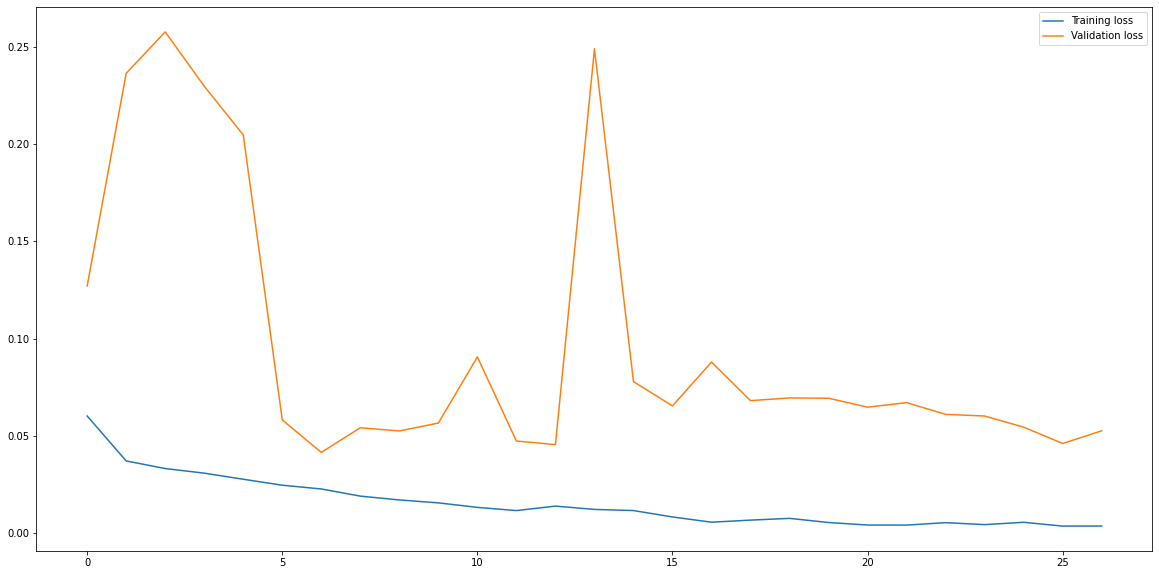

In [105]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [106]:
all_predictions_train = model.predict(X_train)
all_y_train_pred_actual = y_scaler.inverse_transform(all_predictions_train)

predictions_train = model.predict(X_train[180:])
y_pred_train = y_scaler.inverse_transform(predictions_train)

predictions_future = model.predict(X_train[-45:])
y_pred_future = y_scaler.inverse_transform(predictions_future)

In [107]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

r2 = r2_score(y_scaler.inverse_transform(y_train), all_y_train_pred_actual)
rmse = math.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train), all_y_train_pred_actual))
print(r2)
print(rmse)

0.9201869727376114
61.56442034958313


In [93]:
datelist_future = pd.date_range(dates.to_list()[-1], periods=45, freq='1d').tolist()

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['close']).set_index(pd.Series(dates[2 * 180 + 45 -1:]))
PREDICTION_TRAIN.index = pd.DatetimeIndex(PREDICTION_TRAIN.index)

PREDICTION_TRAIN.head(3)

,close
formatted_date,
2018-02-15,1077.445190
2018-02-16,1077.510376
2018-02-20,1079.512207


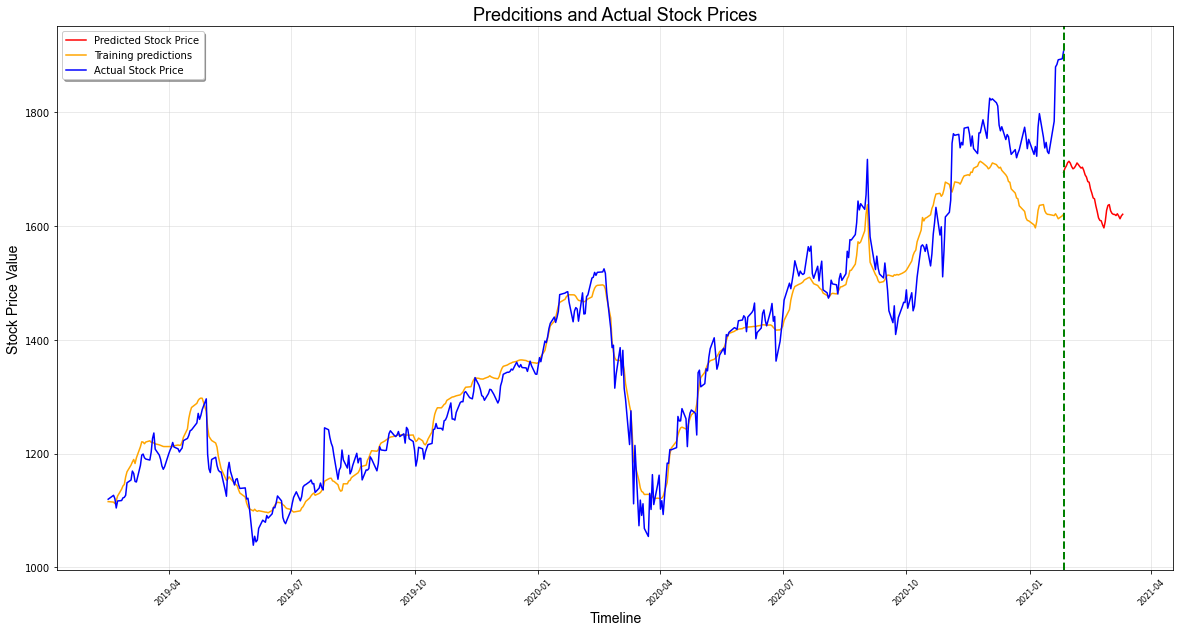

In [94]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

# Plot parameters
START_DATE_FOR_PLOTTING = '2019-02-15'

dates = list(dates)
df['Date'] = dates
df.set_index('Date', inplace=True)
df.index = pd.DatetimeIndex(df.index)

fig= plt.figure()
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['close'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['close'], color='b', label='Actual Stock Price')
plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')
plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Actual Stock Prices', family='Arial', fontsize=18)
plt.xlabel('Timeline', family='Arial', fontsize=14)
plt.ylabel('Stock Price Value', family='Arial', fontsize=14)
plt.xticks(rotation=45, fontsize=8)
plt.show(fig)